In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from __future__ import print_function
from pprint import pprint
from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from astropy.table import Table
%matplotlib inline

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()  
print(lc.flux)

[7916.004  7931.981  7910.661  ... 7843.703  7822.35   7789.4023]


In [3]:
import lightkurve.injection as inj
import lightkurve.lightcurve as lightcurve

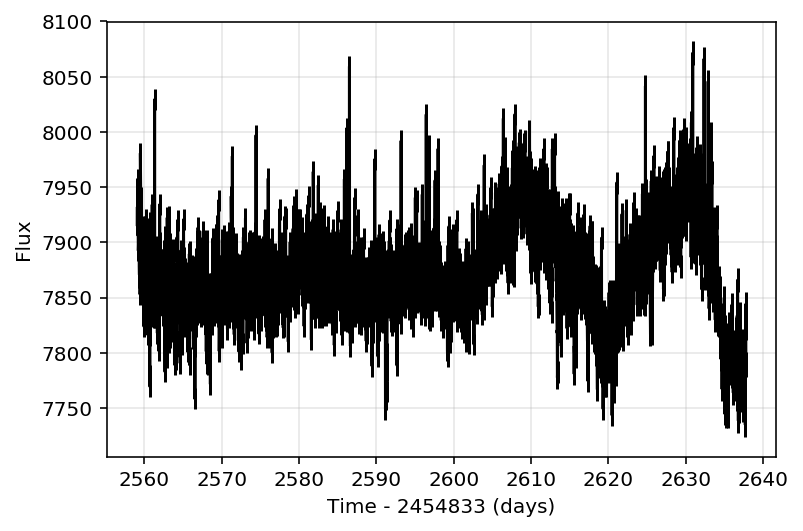

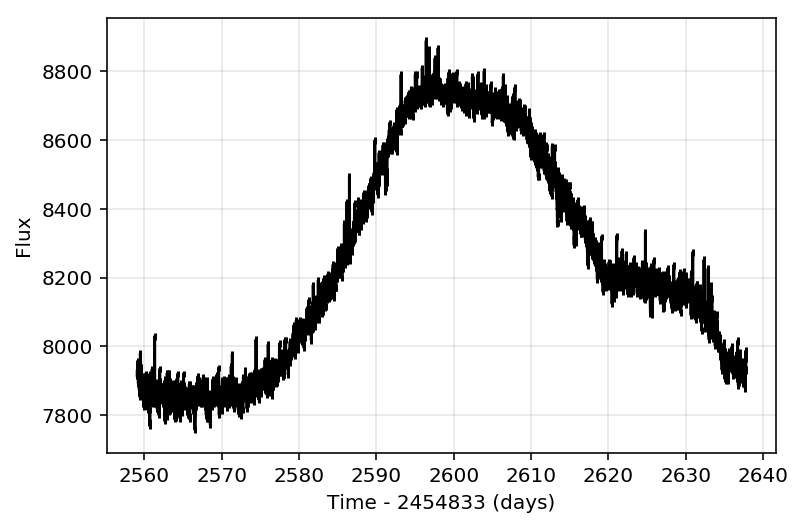

In [4]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=3.e-4)
lcinj = inj.inject(lc, model)
lc.plot(normalize=False)
lcinj.plot(normalize=False);

# Fit by eye

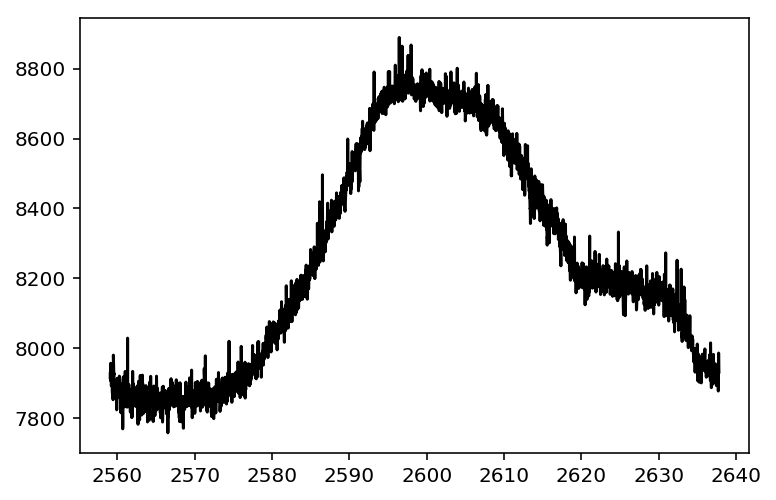

In [6]:
plt.plot(lcinj.time, lcinj.flux, color='k')

Make a model to overplot

In [7]:
model_fit = inj.SupernovaModel(T0=2620, source='hsiao', bandpass='kepler', z=0.4, amplitude=4.3e-4)
model_eval = model_fit.evaluate(lc.time) + 7800

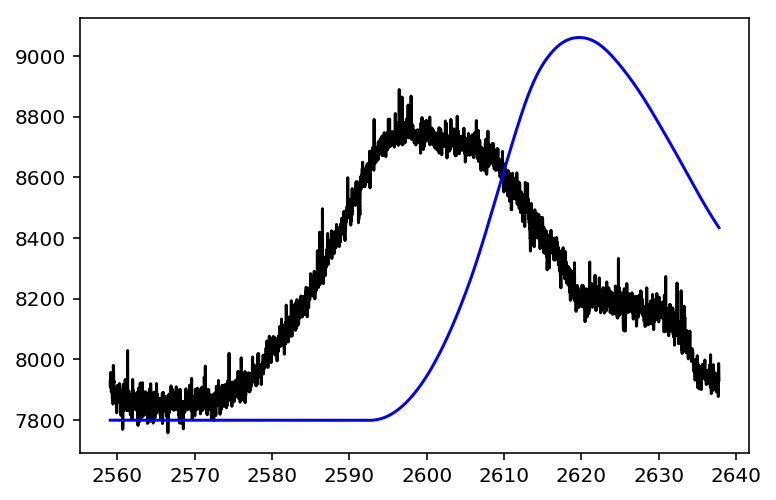

In [8]:
plt.plot(lcinj.time, lcinj.flux, color='k', label='Injected Supernova')
plt.plot(lcinj.time, model_eval, color='b', label='Fit by eye')

In [10]:
best_fit_parameters = inj.recover(lc, 'Supernova')

In [11]:
best_fit_parameters

array([ 2.60500000e+03,  1.00000000e-01, -1.33724011e+00,  7.78978709e+03])

In [12]:
model_min_chisq = inj.SupernovaModel(T0=2605, source='hsiao', bandpass='kepler', z=0.1, amplitude=-1.33724011)
model_eval = model_min_chisq.evaluate(lc.time) + 7789

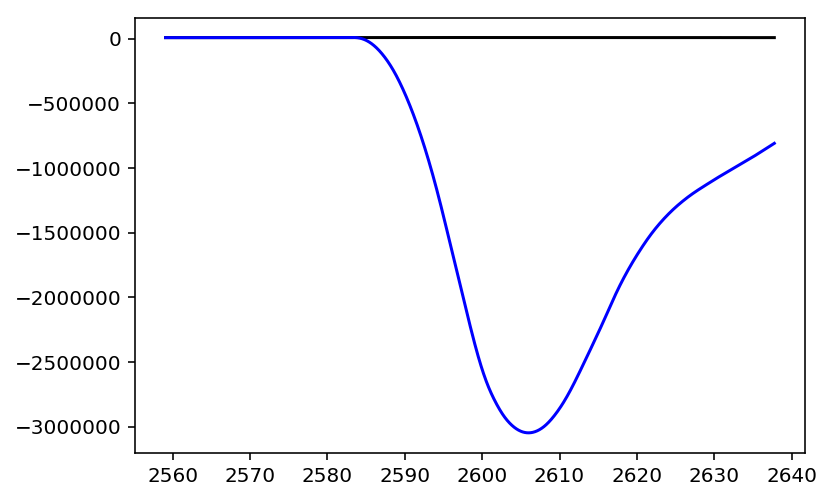

In [13]:
plt.plot(lcinj.time, lcinj.flux, color='k', label='Injected Supernova')
plt.plot(lcinj.time, model_eval, color='b', label='Fit by Chisq')

In [27]:
chisqs = []
#tts = np.arange(7700, 8000, 20)
tts = np.arange(2590, 2635, 1)
for tt in tts:
    chisq = inj.recover(lcinj, 'Supernova',  [tt,  0.1, 4.34e-04,  7900])
    chisqs.append(chisq)

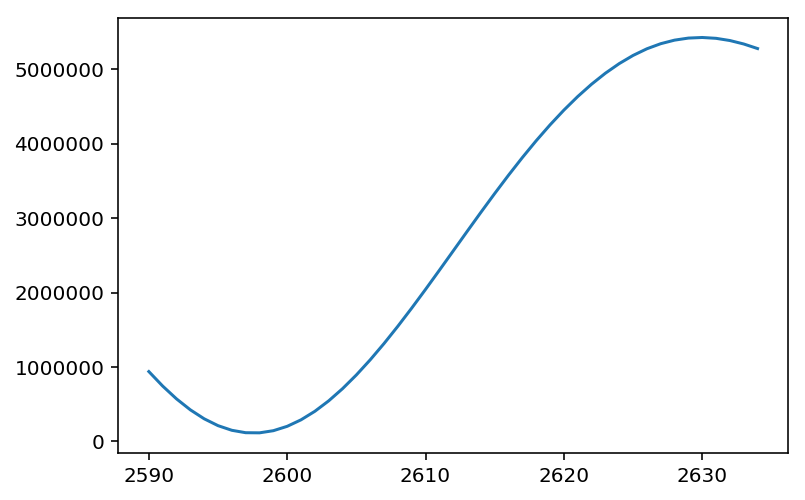

In [28]:
plt.plot(tts, chisqs)

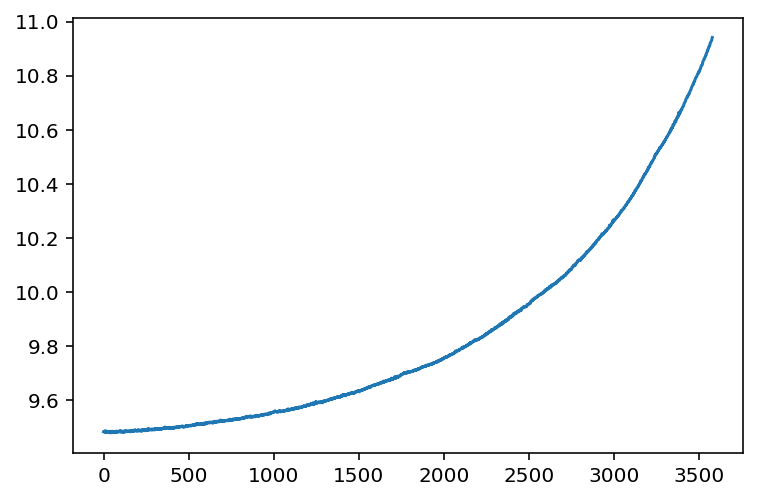

In [32]:
plt.plot(lcinj.flux_err)

It doesn't work!

In [14]:
from scipy.optimize import minimize

In [ ]:
minimize()

In [56]:
def neg_log_like(theta):
    T0, z, amplitude, background_flux = theta
    if (z>0.5) | (z <0):
        return 1.0e99
    else:
        supernova_model = inj.SupernovaModel(T0, z=z, amplitude=amplitude)
        supernova_flux = supernova_model.evaluate(lc.time)
        net_model_flux = supernova_flux + background_flux

        residual = lc.flux - net_model_flux
        return 0.5 * np.sum((residual / lc.flux_err )**2)

In [57]:
initial_guesses = [2605, 0.1, 4.0e-4, 7900.0]

In [58]:
results = minimize(neg_log_like, initial_guesses)

In [59]:
results

      fun: 43854.00386620369
 hess_inv: array([[ 1.00000000e+00,  2.19511771e-09,  2.50553931e-06,
         1.54219281e-12],
       [ 2.19511771e-09,  9.99999232e-01, -8.76106033e-04,
        -5.39101859e-10],
       [ 2.50553931e-06, -8.76106033e-04,  7.67569047e-07,
        -6.15331403e-07],
       [ 1.54219281e-12, -5.39101859e-10, -6.15331403e-07,
         1.00000000e+00]])
      jac: array([  249.73876953, -3281.15576172, 31255.84521484,   712.0390625 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 48
      nit: 1
     njev: 6
   status: 2
  success: False
        x: array([ 2.60500000e+03,  9.99996403e-02, -1.06274393e-05,  7.90000000e+03])

In [72]:
model_eval = model_eval / np.nanmedian(model_eval)
model_synth_fit = lightcurve.SyntheticLightCurve(lc.time, flux=model_eval)

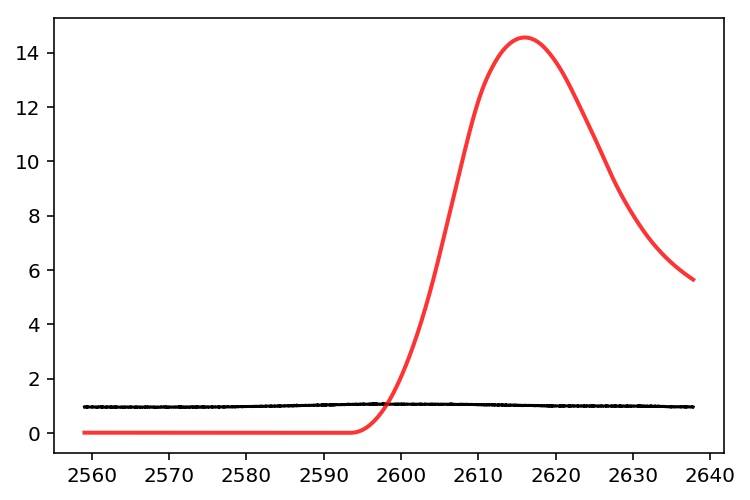

In [73]:
#lcinj.plot()
plt.plot(lc.time, lcinj.flux, color='k')
plt.plot(lc.time, model_synth_fit.flux, color='red', lw=2, ls='-',
        alpha=0.8)
#model_synth_fit.plot()

In [297]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

In [298]:
model = inj.TransitModel()
model.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model.add_planet(period=5, T0=134, rprs=.1, impact=0.0)


lc_transit = inj.inject(lc, model)
lc_transit = lc_transit.normalize()

(0.985, 1.004)

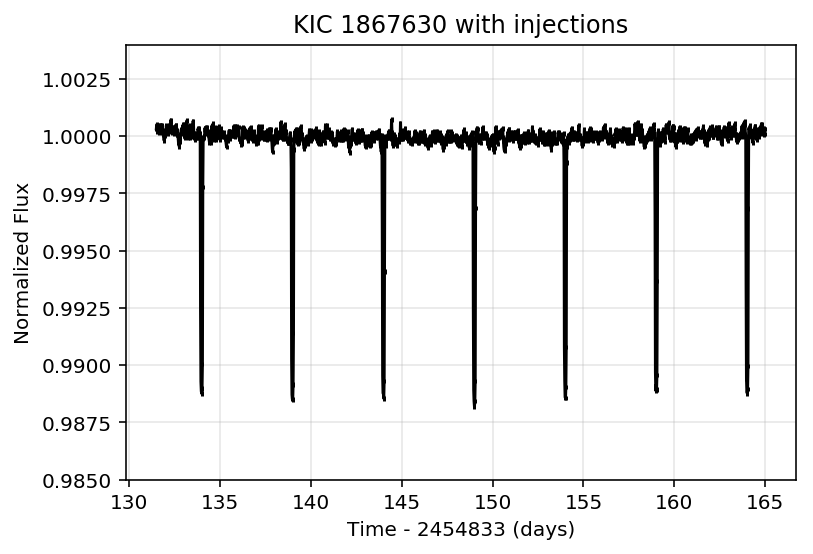

In [299]:
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)

In [300]:
fit = inj.recover(lc_transit, 'Planet')
print(fit)
#T0, period, rprs, impact = theta

[1.35512661e+02 5.00000000e+00 1.00000000e-01 0.00000000e+00]


In [301]:
model_fit = inj.TransitModel()
model_fit.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model_fit.add_planet(period=fit[1], T0=fit[0], rprs=fit[2], impact=fit[3])
model_fit = model_fit.evaluate(lc.time)

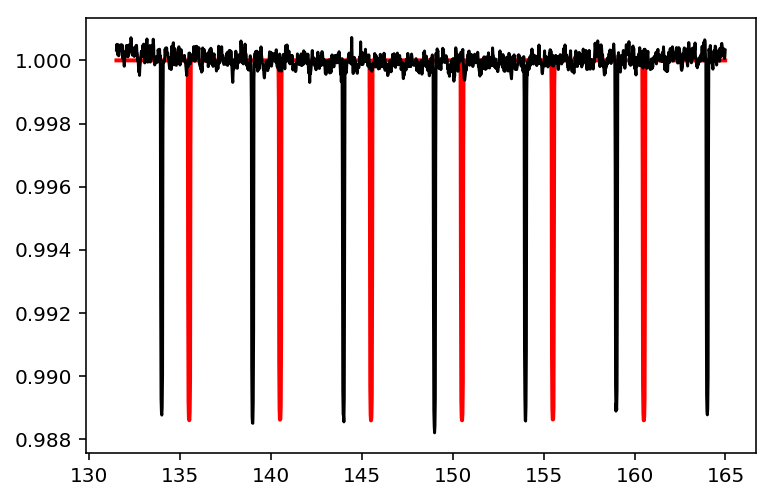

In [302]:
plt.plot(lc.time, model_fit, color = 'r', lw=2)
plt.plot(lc.time, lc_transit.flux, color='k')